In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import matplotlib
import matplotlib.cm as cm


In [2]:
file = open("C:/Users/vkuma/PresseLab/Research/200 5170.375220631081 3626.601735051907variables.pkl", "rb")
variables = pickle.load(file)
file = open("C:/Users/vkuma/PresseLab/Research/200 5170.375220631081 3626.601735051907data.pkl", "rb")
data = pickle.load(file)
file = "C:/Users/vkuma/PresseLab/Research/200(5170.375220631081 3626.601735051907).h5"
f = h5py.File(file, 'r')
dVect= f['samples'][()]
pVect = f['prob'][()]

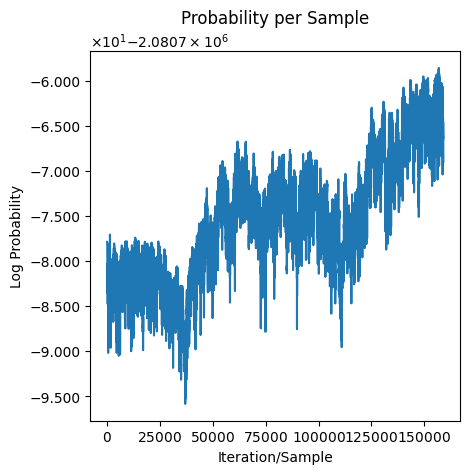

In [11]:
#generate plot
fig, ax = plt.subplots(1, 1)
plt.plot(pVect[1:])
plt.title("Probability per Sample")
plt.xlabel("Iteration/Sample")
plt.ylabel("Log Probability")
plt.ticklabel_format(useMathText=True)
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "%1.3f"
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(yScalarFormatter)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

C:\Users\vkuma\AppData\Local\Temp\ipykernel_21256\1462480234.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(m, shrink = 0.5, anchor = (0.5, 0.5))


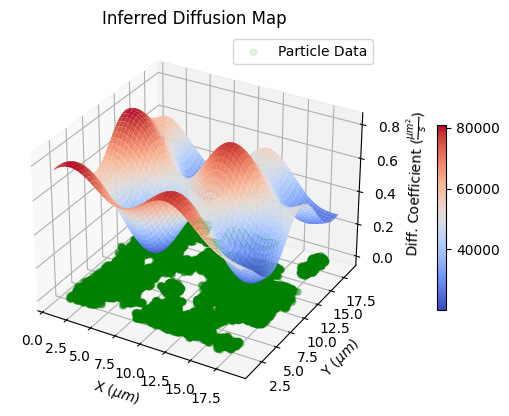

In [27]:
#necassary variables
nFineX = variables.nFineX
nFineY = variables.nFineY
cInduFine = variables.cInduFine
cInduInduInv = variables.cInduInduInv
fineCoordinates = variables.fineCoordinates
trajectories = data.trajectories
induCoordinates = variables.induCoordinates 

#shape for plot
shape = (nFineX, nFineY)

#take mean of all samples
unshapedMap = (cInduFine.T @ (cInduInduInv @ np.mean(dVect[1:], 0)))

#reshape variables to make plotting easy
shapedMap = np.reshape(unshapedMap, shape)
shapedX = np.reshape(fineCoordinates[:,0], shape)
shapedY = np.reshape(fineCoordinates[:,1], shape)




#generate contour plot
fig = plt.axes(projection='3d')
fig.plot_surface(shapedX/1000, shapedY/1000, shapedMap/100000, cmap=cm.coolwarm)
fig.scatter3D(trajectories[:,0]/1000, trajectories[:,1]/1000, 0, color = "green", alpha = 0.1, label = "Particle Data")
#fig.scatter3D(induCoordinates[:,0], induCoordinates[:,1], 0, color = "black", alpha = 0.5, label = "Inducing Points")
fig.set_xlabel(r"X ($\mu m$)")
fig.set_ylabel(r"Y ($\mu m$)")
fig.set_zlabel(r"Diff. Coefficient ($\frac{\mu m^2}{s}$)")
fig.set_title("Inferred Diffusion Map");
#ticks = np.arange(0, 10/100, 2/100)
fig.legend()
#fig.set_zticks(ticks)
norm = matplotlib.colors.Normalize(vmin=np.min(shapedMap), vmax=np.max(shapedMap))
m = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
m.set_array([])
plt.colorbar(m, shrink = 0.5, anchor = (0.5, 0.5))

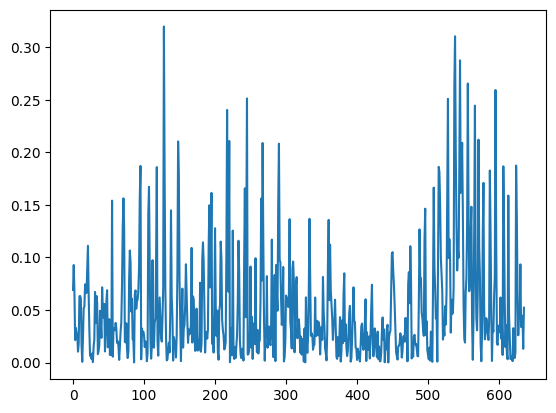

In [16]:
from scipy.spatial import KDTree
def find_closest_point_indices(target_point, points, k=20):
    kdtree = KDTree(points)
    distances, indices = kdtree.query(target_point, k=k)
    return indices

diff = variables.sampleCoordinates - variables.dataCoordinates
dMleData = np.sum(diff*diff, axis = 1)/(4*data.deltaT)
k = 2000
dIndu = variables.dIndu.copy()

for i in range(variables.nIndu):
    closest = find_closest_point_indices(variables.induCoordinates[i], variables.dataCoordinates, k=k)
    dIndu[i] = np.mean(dMleData[closest])

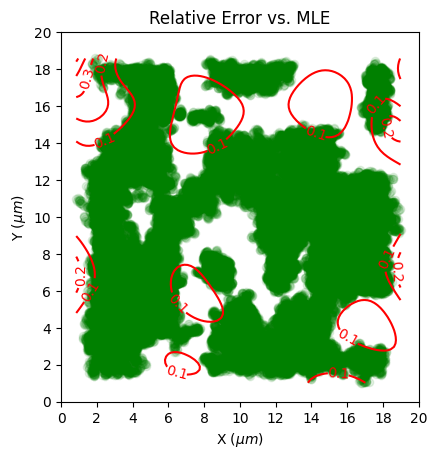

In [26]:
groundTruth = cInduFine.T @ cInduInduInv @ dIndu
shape = (nFineX, nFineY)
unshapedMap = cInduFine.T @ cInduInduInv @ np.mean(dVect[50000:], 0)

shapedGroundTruth = np.reshape(groundTruth, shape)
shapedMap = np.reshape(unshapedMap, shape)
shapedX = np.reshape(fineCoordinates[:,0], shape)
shapedY = np.reshape(fineCoordinates[:,1], shape)
diff = (np.abs((shapedGroundTruth - shapedMap))/shapedGroundTruth)
fig, ax = plt.subplots(1, 1)

mapPlot = plt.contour(shapedX/1000, shapedY/1000, diff, colors = 'r', levels = [.1, .2, .3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9, 1])
plt.xlabel(r"X ($\mu m$)")
plt.ylabel(r"Y ($\mu m$)")
plt.title('Relative Error vs. MLE')
plt.scatter(trajectories[:,0]/1000, trajectories[:,1]/1000, color = "green", alpha = 0.1, label = "Particle Data")
plt.clabel(mapPlot, inline=2, fontsize=10)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.set_xticks(np.linspace(0, 20, 11));
ax.set_yticks(np.linspace(0, 20, 11));